# Laboratorio 2: Armado de un esquema de aprendizaje automático

Estudiante: Mariano Martín Gualpa (mgualpa@gmail.com)

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [58]:
import numpy as np
import pandas as pd

# TODO: Agregar las librerías que hagan falta

from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ml.visualization import plot_confusion_matrix, classifier_boundary
from sklearn.datasets import load_boston, load_breast_cancer, load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from ml.visualization import plot_confusion_matrix, plot_learning_curve
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.utils import resample

%matplotlib inline



Parametros generales de trabajo:

In [59]:
fileName = "./data/loan_data.csv"
trainSizePercent = 0.80
foldersNSplits = 5
randomSeed = 0
useScoringRocAuc = True
forceBalance = True


## Carga de datos

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [60]:
np.random.seed(randomSeed)  # Para mayor determinismo
dataset = pd.read_csv(fileName, comment="#")
display(dataset.head())
countRows = len(dataset) 
print("Cantidad total de registros del dataset: ", countRows)
# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


Cantidad total de registros del dataset:  1854


## Ejercicio 1: División de datos en conjuntos de entrenamiento y evaluación

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (o *training*) y evaluación (o *test*).

El primero será utilizado para la creación/selección del modelo de clasificación. El segundo se utilizará sólo al final (una vez elegidos los mejores hiperparámetros) para ver cuál es el resultado final del modelo sobre un conjunto de datos independiente.

In [61]:
def printBalance(y):
    yCount = y.count()
    yTrue = y.sum()
    yFalse = yCount - yTrue
    class1Percent = yTrue / yCount
    class0Percent = yFalse / yCount
    print("Total registros: {0:}  Total clase 1: {1:} ({2:.4f}%)  Total clase 0: {3:} ({4:.4f}%)".format(yCount, yTrue, class1Percent, yFalse, class0Percent))

def printBal(y):
    df_majority = y[y==0]
    df_minority = y[y==1]
    print(df_majority.count(), df_minority.count())
 
print(y.value_counts())


0    1545
1     309
Name: TARGET, dtype: int64


Dado que en el mínimo análisis exploratorio previo, se observa un desbalance importante entre las clases 1 y 0, esto afecta a la capacidad de predicción, por lo que se agrega el código para balancear el conjunto utilizado. Se controla su utilización con el parámetro *forceBalance*.

In [62]:
if forceBalance:
    # Forzar balance (generar un dataset con igual cantidad de elementos por clase). 
    # Fuente: https://elitedatascience.com/imbalanced-classes
    X_true = X[y==1]  # Minoría
    y_true = y[y==1]  # Minoría
    X_false = X[y==0] # Mayoría
    y_false = y[y==0] # Mayoría
    nSampleMin = y_true.count()
    XFalseDownsampled = resample(X_false, 
                                 replace=False,    
                                 n_samples=nSampleMin, 
                                 random_state=123) 
    yFalseDownsampled = resample(y_false, 
                                 replace=False,    
                                 n_samples=nSampleMin, 
                                 random_state=123) # En este caso, al ser siempre 0 no hay problema con resample
 
    X = pd.concat([XFalseDownsampled, X_true])
    y = pd.concat([yFalseDownsampled, y_true])
    print(y.value_counts())



1    309
0    309
Name: TARGET, dtype: int64


En el diseño de este trabajo, se decide utilizar:
* 80% para entrenamiento.
* 20% para test.


In [63]:
# TODO: Dividir en datos de entrenamiento y evaluación
testSizePercent = 1 - trainSizePercent
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = trainSizePercent, test_size = testSizePercent)

print("Tamaño del conjunto de entrenamiento: {}  Tamaño del conjunto de test: {}".format(len(X_train), len(X_test)))



Tamaño del conjunto de entrenamiento: 494  Tamaño del conjunto de test: 124


## Ejercicio 2: Elección de un modelo

Basándose en lo visto en el teórico escojan y justifiquen un modelo de aprendizaje automático. Recuerden que los pasos para elegir un modelo son:



### Selección de hipótesis

La hipótesis general de trabajo es que se trata de un problema de clasidicación y que los atributos disponibles en el dataset permitirán predecir con una probabilidad de error razonable si el atributo objetivo TARGET será 1 (el préstamo no será pagado) ó 0 (el préstamo si será pagado).

Se asume para el modelo una hipótesis Lineal para el modelo de clasificación.


### Selección de regularizador

Se selecciona para este trabajo un regularizador de tipo l2. 


### Selección de función de coste

Se ha seleccionado una función de costo del tipo: Binary Loss.


### Justificación de las selecciones

La hipótesis general se justifica por la naturaleza del problema: detectar a futuro la clase a la que pertenecen los registros nuevos que no tienen aún una clase definida, a partir de un modelo construido sobre el aprendizaje de registros pasados y su clasificación conocida.

La hipótesis de utilización de un clasificador de Regresión Logística se sustenta en la naturaleza del problema: clasificación. Podrían haberse utilizado otros modelos (como árboles, vecinos mas cercanos o redes neuronales). No obstante, dadas las condiciones del práctico (indicar regularizador y función de coste), resulta mas conveniente pues el modelo seleccionado cuenta con todos estos elementos.

La función de regularizador l2 fue inicialmente seleccionada porque se considera que da un único resultado (a diferencia del l1). De cualquier manera, se comprobó que dio mejor resultado en la búsqueda grid.

La selección de la función de coste como binary loss, se sustenta en la naturaleza del problema (clasificación) utilizando regresión logística. 



## Ejercicio 3: Selección de hiperparámetros

Utilizando búsqueda exhaustiva (*grid search*) con *5-fold cross-validation* y utilizando como métrica el área bajo la curva de ROC (o *ROC-AUC*), hagan una selección de los mejores hiperparámetros para su conjunto de datos y el modelo que hayan elegido en el apartado anterior.

In [64]:
# TODO: Selección de hiperparámetros

param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'tol': [0.001, 0.0001, 0.00001], 'max_iter': [100, 1000], 'penalty' : ['l1', 'l2']}

cv = KFold(n_splits=foldersNSplits, shuffle=True)
if useScoringRocAuc:
    grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv, scoring='roc_auc')
else:
    grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
trainScore = grid.score(X_train, y_train)
print("Train Score: {}".format(trainScore))  
print("Mejores Parámetros: {} ".format(grid.best_params_)) 


Train Score: 0.8457831325301205
Mejores Parámetros: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'tol': 1e-05} 


## Ejercicio 4: Métricas sobre el conjunto de evaluación

Una vez encontrados los mejores hiperparámetros para el modelo seleccionado en los apartados anteriores se evalúa el modelo final entrenado sobre el conjunto de datos de evaluación seleccionado en el ejercicio 1. Pueden utilizar las métricas que crean convenientes. Es mejor utilizar más de una métrica. Particularmente el *reporte de clasificación* y la *matriz de confusión* son buenos ejemplos de métricas.

Test Score: 0.7317708333333334
Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

             precision    recall  f1-score   support

          0       0.65      0.75      0.70        60
          1       0.73      0.62      0.67        64

avg / total       0.69      0.69      0.68       124





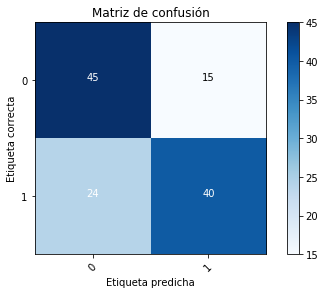

In [65]:
# TODO: Evaluación del modelo
def showTestMetrics(model, X_test, y_test):
    testScore = model.score(X_test, y_test)
    print("Test Score: {}".format(testScore))  
    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred), end="\n\n")
    print("================================================", end="\n\n")
    plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=[0, 1], title="Matriz de confusión")

showTestMetrics(grid, X_test, y_test)


## Ejercicio 5 (opcional): Curvas de ROC

Como ejercicio adicional (opcional), pueden redefinir el umbral de decisión óptimo del problema a partir de los resultados que muestren curvas de ROC como justificación. 

Pueden ver esto mediante la [graficación de las curvas de ROC](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). En el link que se les brinda se muestra como hacer para graficar curvas de ROC para problemas multiclase. Sin embargo se puede adaptar fácilmente a un problema binario obviando la parte donde se calcula la curva clase por clase.

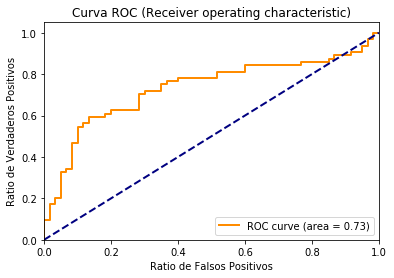

In [66]:
# TODO: Redefinir umbral de clasificación a través de los resultados vistos por graficar curvas de ROC
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


y_score = grid.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test[:], y_score[:])
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de Falsos Positivos')
plt.ylabel('Ratio de Verdaderos Positivos')
plt.title('Curva ROC (Receiver operating characteristic)')
plt.legend(loc="lower right")
plt.show()
